In [32]:
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [33]:
data_dir = 'insects-recognition'

In [34]:
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 10306 images belonging to 12 classes.
Found 1143 images belonging to 12 classes.


In [35]:
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))
base_model.load_weights('inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

base_model.trainable = False

In [44]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(12, activation='softmax') 
])

In [45]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 12)                12300     
                                                                 
Total params: 23,913,260
Trainable params: 2,110,476
Non-trainable params: 21,802,784
__________________________________

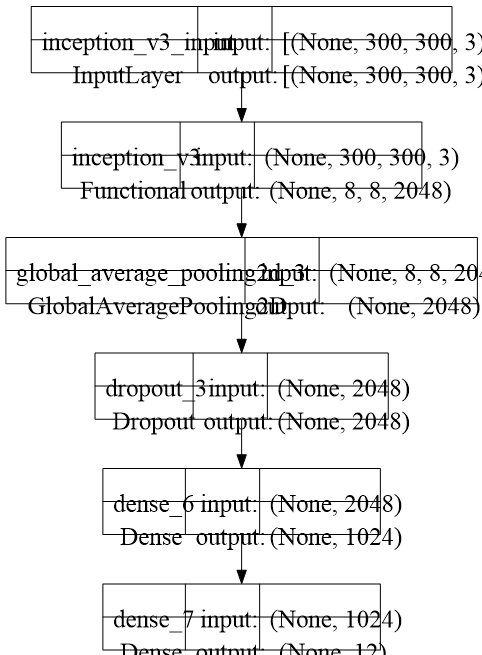

In [47]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [48]:
batch_size = 32
epochs = 10

train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [49]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 322
validation_steps : 35


In [50]:
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]

history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
322/322 [==============================] - ETA: 0s - loss: 0.9427 - accuracy: 0.7127
Epoch 1: val_accuracy improved from -inf to 0.84554, saving model to .\model_01-0.85.h5
322/322 [==============================] - 559s 2s/step - loss: 0.9427 - accuracy: 0.7127 - val_loss: 0.4999 - val_accuracy: 0.8455
Epoch 2/10
322/322 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.8197
Epoch 2: val_accuracy improved from 0.84554 to 0.84732, saving model to .\model_02-0.85.h5
322/322 [==============================] - 569s 2s/step - loss: 0.5680 - accuracy: 0.8197 - val_loss: 0.4573 - val_accuracy: 0.8473
Epoch 3/10
322/322 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.8343
Epoch 3: val_accuracy improved from 0.84732 to 0.86339, saving model to .\model_03-0.86.h5
322/322 [==============================] - 594s 2s/step - loss: 0.5072 - accuracy: 0.8343 - val_loss: 0.4306 - val_accuracy: 0.8634
Epoch 4/10
322/322 [==========================

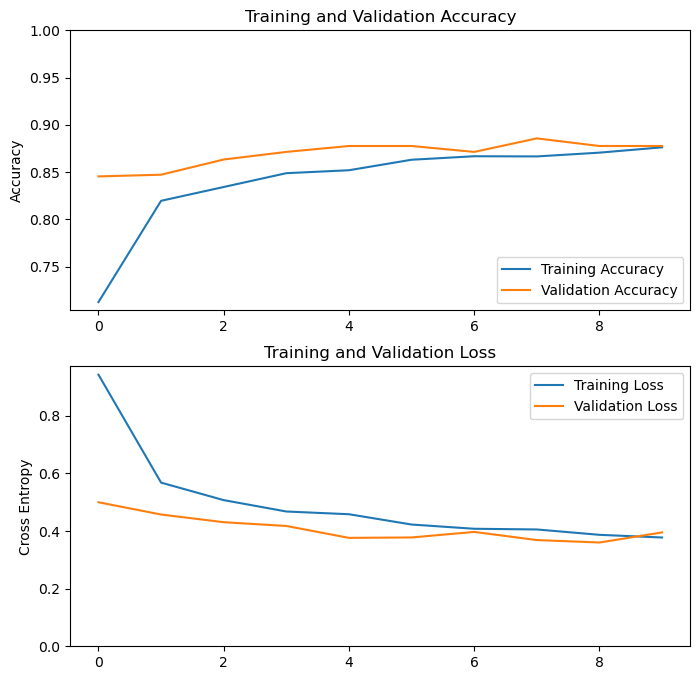

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')



plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [52]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

36/36 [==============================] - 50s 1s/step - loss: 0.3932 - accuracy: 0.8766
test accuracy :  0.8766404390335083


In [63]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("model_08-0.89.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
        img = image.load_img(img_rel_path, target_size=(300, 300))
    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)
    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {
                0: 'Bees',
                1: 'Beetles',
                2: 'Butterfly',
                3: 'Cicada',
                4: 'Dragonfly',
                5: 'Grasshopper',
                6: 'Ladybird',
                7: 'Mosquito',
                8: 'Moth',
                9: 'Scorpion',
                10: 'Snail',
                11: 'Spider'
            }
    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

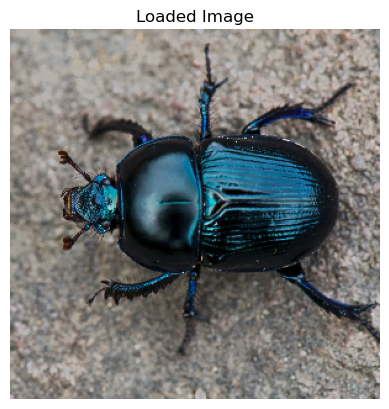

1/1 [==============================] - 0s 82ms/step


Maximum Probability:  0.9801097
Classified: Beetles 



-------------------Individual Probability--------------------------------

BEES : 0.02 %
BEETLES : 98.01 %
BUTTERFLY : 0.39 %
CICADA : 0.09 %
DRAGONFLY : 0.39 %
GRASSHOPPER : 0.19 %
LADYBIRD : 0.63 %
MOSQUITO : 0.06 %
MOTH : 0.01 %
SCORPION : 0.08 %
SNAIL : 0.04 %
SPIDER : 0.09 %


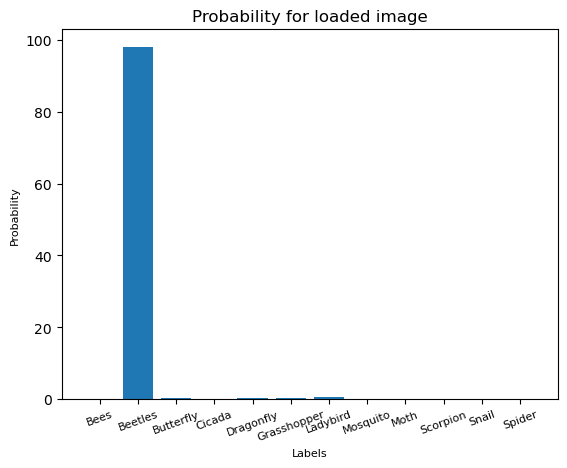

In [73]:
predict("testingImages/beetle.jpg")

In [ ]:
  labels = {
                0: 'Bees',
                1: 'Beetles',
                2: 'Butterfly',
                3: 'Cicada',
                4: 'Dragonfly',
                5: 'Grasshopper',
                6: 'Ladybird',
                7: 'Mosquito',
                8: 'Moth',
                9: 'Scorpion',
                10: 'Snail',
                11: 'Spider'
class_names = ['Bees', 'Beetles', 'Butterfly', 'Cicada','Dragonfly','Grasshopper', 'Ladybird','Mosquito', 'Moth', 'Scorpion','Snail','Spider']